In [105]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import operator
import matplotlib
matplotlib.use("Agg") #Needed to save figures
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

In [86]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [87]:
print("Load the training, test and store data using pandas")
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str)}
train = pd.read_csv("train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv("store.csv")


Load the training, test and store data using pandas


In [88]:
print("Assume store open, if not provided")
train.fillna(1, inplace=True)
test.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train = train[train["Open"] != 0]
print("Use only Sales bigger then zero. Simplifies calculation of rmspe")
train = train[train["Sales"] > 0]

print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')


Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero. Simplifies calculation of rmspe
Join with store


In [89]:
features = []

print("augment features")
build_features(features, train)
build_features([], test)
print(features)

print('training data processed')


augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
training data processed


In [90]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 300

print("Train a XGBoost model")
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)


Train a XGBoost model
[0]	train-rmspe:0.996841	eval-rmspe:0.996842
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmspe:0.981536	eval-rmspe:0.981554
[2]	train-rmspe:0.938201	eval-rmspe:0.938294
[3]	train-rmspe:0.856727	eval-rmspe:0.856863
[4]	train-rmspe:0.743942	eval-rmspe:0.743855
[5]	train-rmspe:0.618844	eval-rmspe:0.617827
[6]	train-rmspe:0.502389	eval-rmspe:0.499632
[7]	train-rmspe:0.408672	eval-rmspe:0.402631
[8]	train-rmspe:0.342451	eval-rmspe:0.331743
[9]	train-rmspe:0.300751	eval-rmspe:0.285306
[10]	train-rmspe:0.282217	eval-rmspe:0.262427
[11]	train-rmspe:0.273396	eval-rmspe:0.251397
[12]	train-rmspe:0.269791	eval-rmspe:0.246297
[13]	train-rmspe:0.269702	eval-rmspe:0.245751
[14]	train-rmspe:0.272773	eval-rmspe:0.247519
[15]	train-rmspe:0.260757	eval-rmspe:0.233813
[16]	train-rmspe:0.256779	eval-rmspe:0.225395
[17]	train-rmspe:0.255951	eval-rmspe:0.224419
[18]	train-rms

[175]	train-rmspe:0.104944	eval-rmspe:0.10153
[176]	train-rmspe:0.104711	eval-rmspe:0.101337
[177]	train-rmspe:0.104354	eval-rmspe:0.101246
[178]	train-rmspe:0.104267	eval-rmspe:0.101235
[179]	train-rmspe:0.104036	eval-rmspe:0.101093
[180]	train-rmspe:0.103863	eval-rmspe:0.101023
[181]	train-rmspe:0.102643	eval-rmspe:0.100965
[182]	train-rmspe:0.102533	eval-rmspe:0.100908
[183]	train-rmspe:0.102384	eval-rmspe:0.100781
[184]	train-rmspe:0.102276	eval-rmspe:0.10071
[185]	train-rmspe:0.102033	eval-rmspe:0.100473
[186]	train-rmspe:0.101898	eval-rmspe:0.100413
[187]	train-rmspe:0.101792	eval-rmspe:0.100301
[188]	train-rmspe:0.101694	eval-rmspe:0.100312
[189]	train-rmspe:0.101125	eval-rmspe:0.100274
[190]	train-rmspe:0.101039	eval-rmspe:0.100253
[191]	train-rmspe:0.100755	eval-rmspe:0.100165
[192]	train-rmspe:0.100606	eval-rmspe:0.100127
[193]	train-rmspe:0.100548	eval-rmspe:0.100109
[194]	train-rmspe:0.100449	eval-rmspe:0.100088
[195]	train-rmspe:0.100362	eval-rmspe:0.100031
[196]	train-rms

In [91]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))


Validating
RMSPE: 0.096499


In [92]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_10_submission.csv", index=False)


Make predictions on the test set


In [93]:
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)



In [94]:
importance_features = gbm.get_fscore(fmap='xgb.fmap')
importance_features

{'Assortment': 3897,
 'CompetitionDistance': 20166,
 'CompetitionOpen': 29052,
 'Day': 32865,
 'DayOfWeek': 23533,
 'IsPromoMonth': 2674,
 'Month': 15710,
 'Promo': 8261,
 'Promo2': 2209,
 'PromoOpen': 23399,
 'SchoolHoliday': 5251,
 'StateHoliday': 396,
 'Store': 27724,
 'StoreType': 5365,
 'WeekOfYear': 24007,
 'Year': 6650}

In [95]:
df = pd.DataFrame(list(importance_features.items()))


In [96]:
df.columns = ["index","score"]
df

,index,score
0,Promo,8261
1,Promo2,2209
2,CompetitionDistance,20166
3,Store,27724
4,Month,15710
5,StoreType,5365
6,Day,32865
7,CompetitionOpen,29052
8,PromoOpen,23399
9,DayOfWeek,23533


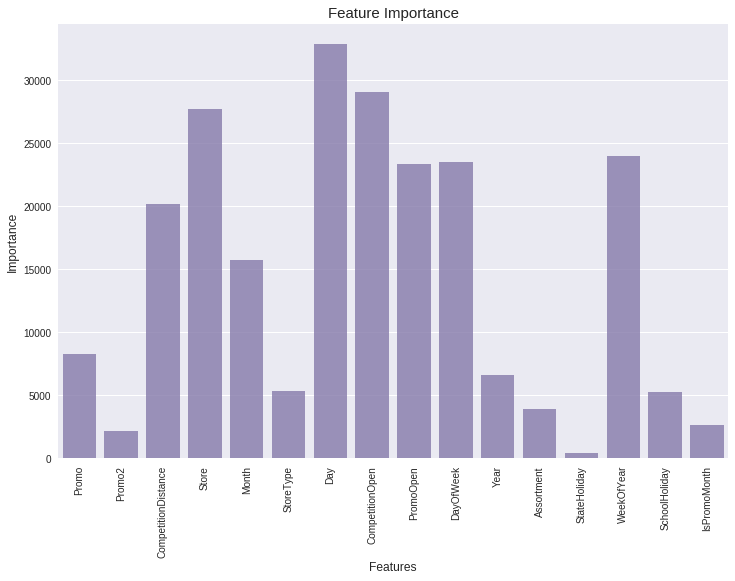

In [107]:
plt.figure(figsize = (12,8))
sns.barplot(x = 'index', y = 'score', data =df, alpha=0.8, color=color[3])
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.title("Feature Importance", fontsize=15)
plt.xticks(rotation='vertical')
#plt.ylim(0.5, 0.7)
plt.show()